In [15]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg
band_def = list(kde.utils.spectral.bands.keys())

In [2]:
save_base = '/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/plots_presentations_etc/pure_rebound_bp'

In [7]:
reb_df_path = '/home/kdriessen/gh_master/acr/pub/data/reb_df.csv'
reb_df = acr.io.read_full_df(folder='rebound_data_1h')
reb_df = reb_df.loc[reb_df.state == 'NREM']
reb_df = reb_df.loc[reb_df['Band']=='delta']
reb_df = reb_df.sort_values('subject')


In [8]:
def get_diff_df(reb_df, sub, exp, band='delta'):
    chans = reb_df.loc[reb_df.exp==exp].sbj(sub).channel.unique()
    avg = reb_df.loc[reb_df.Band==band].loc[reb_df.exp==exp].sbj(sub).groupby(['store', 'channel']).Bandpower.median()
    avgs = avg.to_frame().reset_index()
    diffs = avgs.prb('NNXo').Bandpower.values - avgs.prb('NNXr').Bandpower.values
    diff_df = pd.DataFrame({'channel': chans, 'diff': diffs, "exp":exp, "sub":sub, "band":band})
    return diff_df

def full_subject_diffs(reb_df, sub, band='delta'):
    from acr.utils import swi_subs_exps
    exps = swi_subs_exps[sub]
    dfs = {}
    for exp in exps:
        dfs[exp] = get_diff_df(reb_df, sub, exp, band=band)
    return pd.concat(dfs.values())

def full_subject_all_bands(reb_df, sub):
    bands = list(kde.utils.spectral.bands.keys())
    dfs = {}
    for band in bands:
        dfs[band] = full_subject_diffs(reb_df, sub, band=band)
    return pd.concat(dfs.values())

In [20]:
swi = reb_df.loc[reb_df['exp'].isin(['swi', 'swi2'])]
swisin = reb_df.loc[reb_df['exp'].isin(['swisin', 'swisin2'])]

Text(0, 0.5, 'SWA (0.5-4Hz)')

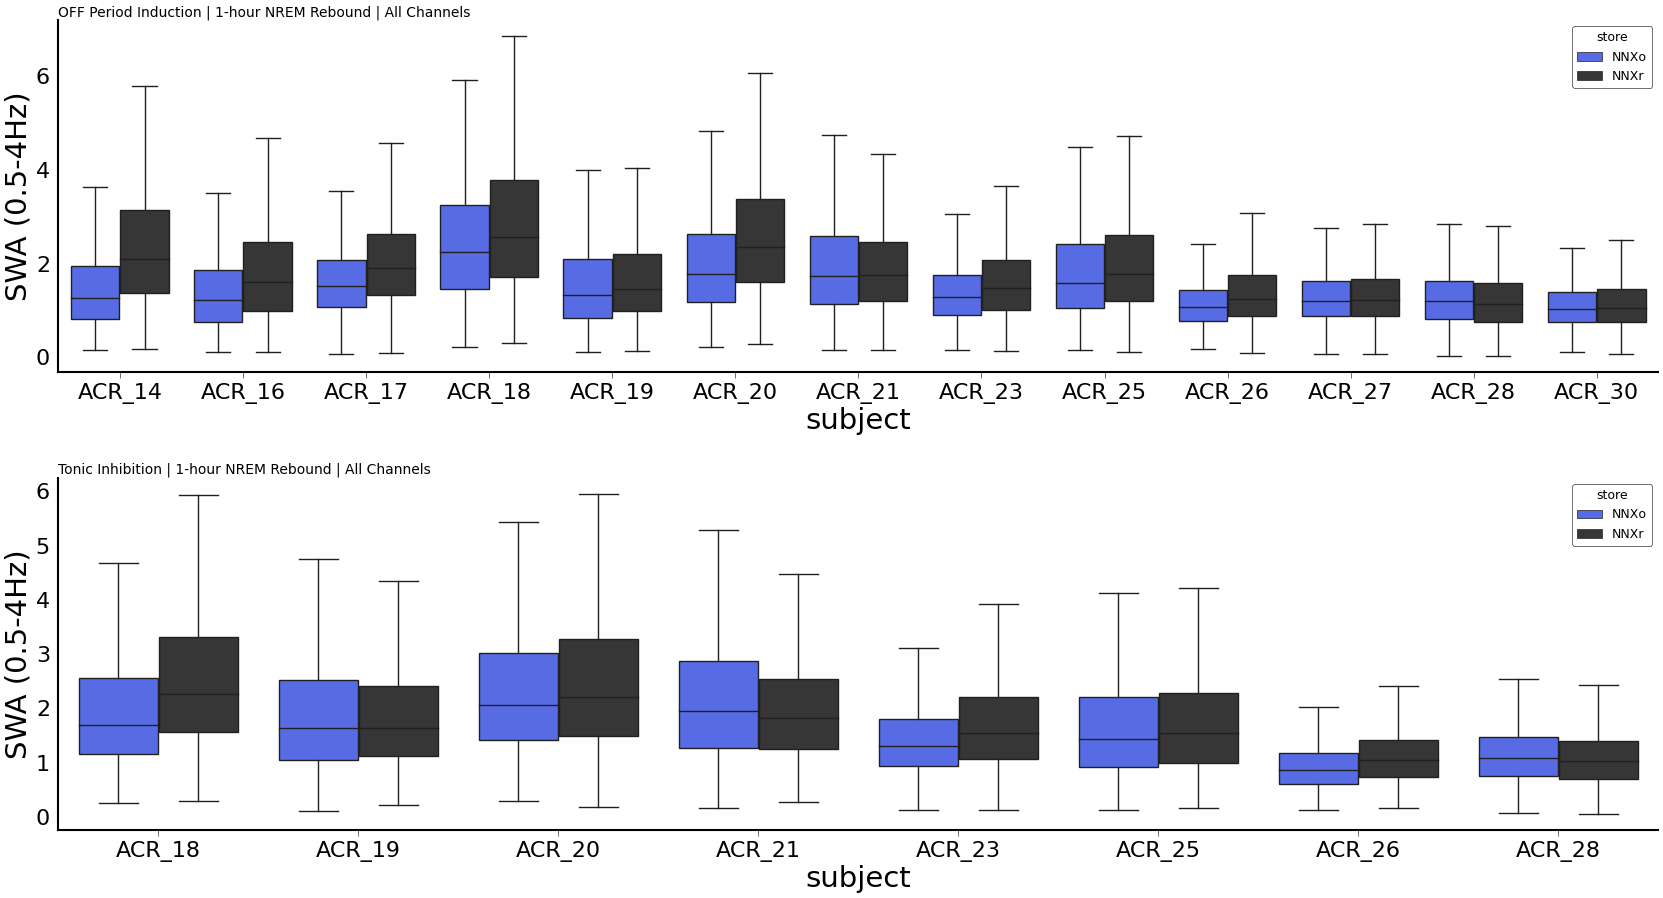

In [23]:
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')
f, ax = plt.subplots(2, 1, figsize = (40, 20))
ax[0] = sns.boxplot(data=swi, x='subject', y='Bandpower', hue='store', showfliers=False, ax=ax[0])
ax[0].set_title('OFF Period Induction | 1-hour NREM Rebound | All Channels')
ax[0].set_ylabel('SWA (0.5-4Hz)')
ax[1] = sns.boxplot(data=swisin, x='subject', y='Bandpower', hue='store', showfliers=False, ax=ax[1])
ax[1].set_title('Tonic Inhibition | 1-hour NREM Rebound | All Channels')
ax[1].set_ylabel('SWA (0.5-4Hz)')

# Exact Matching

In [24]:
def make_rel_df(df, subject):
    sbj_df = pd.DataFrame()
    rel_vals = df.sbj(subject).prb('NNXo')['Bandpower'].values / df.sbj(subject).prb('NNXr')['Bandpower'].values
    assert len(df.sbj(subject)['exp'].unique()) == 1
    sbj_df['rel_bp'] = rel_vals
    sbj_df['channel'] = df.sbj(subject).prb('NNXo')['channel'].values
    sbj_df['layer'] = df.sbj(subject).prb('NNXo')['layer'].values
    sbj_df['subject'] = subject
    sbj_df['datetime'] = df.sbj(subject).prb('NNXo')['datetime'].values
    sbj_df['store'] = 'NNXo'
    sbj_df['exp'] = df.sbj(subject).prb('NNXo')['exp'].values
    sbj_df['exp_type'] = df.sbj(subject).prb('NNXo')['exp_type'].values
    sbj_df['state'] = df.sbj(subject).prb('NNXo')['state'].values
    sbj_df['region'] = df.sbj(subject).prb('NNXo')['region'].values
    sbj_df['channel'] = sbj_df['channel'].astype('str')
    return sbj_df

In [27]:
all_subs = {}
for sub in swi.subject.unique():
    all_subs[sub] = make_rel_df(swi, sub)
swi_rel = pd.concat(all_subs.values())

all_subs = {}
for sub in swisin.subject.unique():
    all_subs[sub] = make_rel_df(swisin, sub)
swisin_rel = pd.concat(all_subs.values())

In [28]:
swa_rel = pd.concat([swi_rel, swisin_rel])

Text(0, 0.5, 'SWA (0.5-4Hz) | NNXo / NNXr')

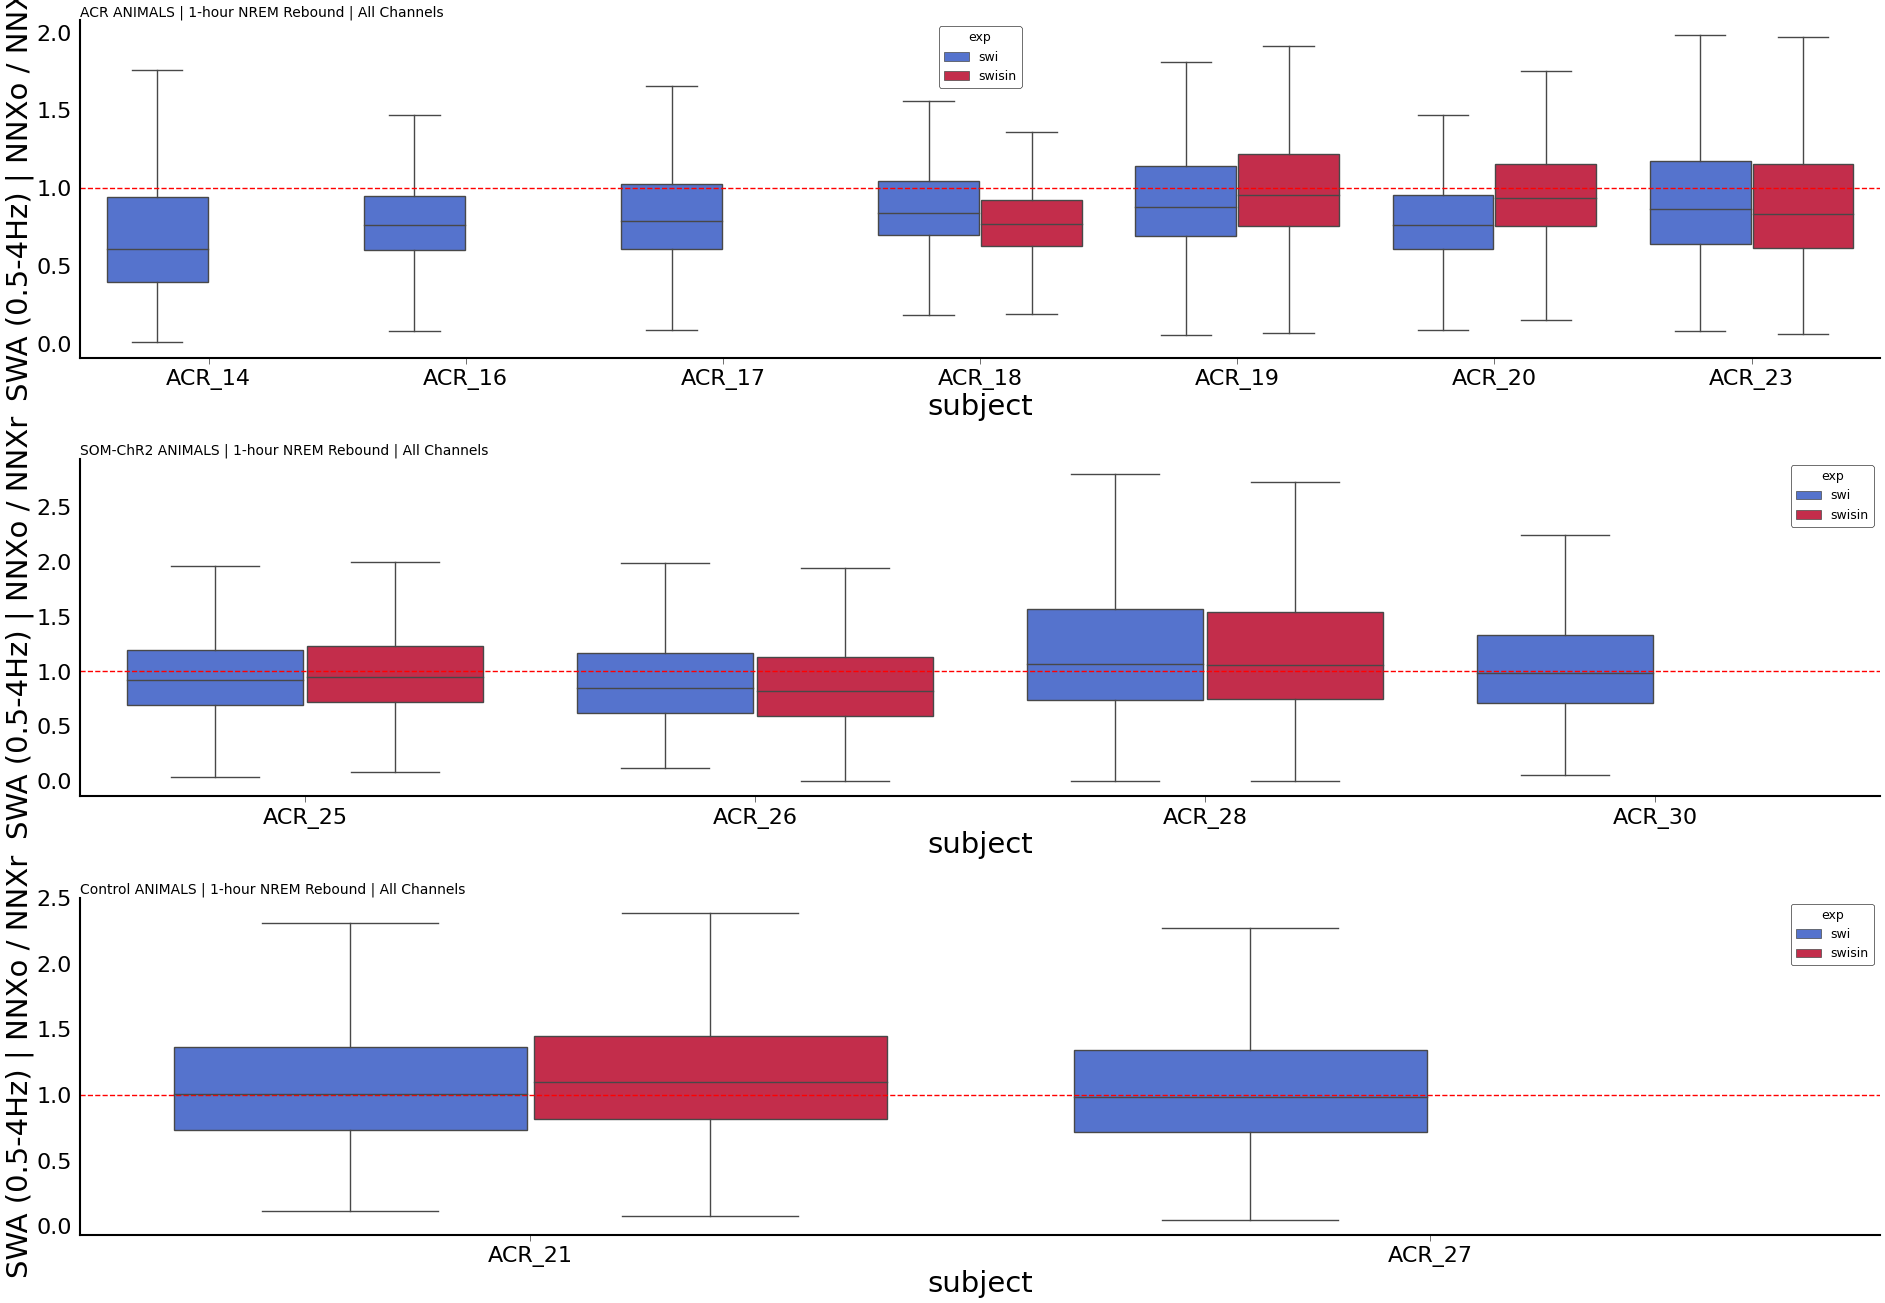

In [31]:
f, ax = plt.subplots(3, 1, figsize = (45, 30))
sns.boxplot(data=swa_rel.exptype('acr').exp_names(), x='subject', y='rel_bp', hue='exp', showfliers=False, ax=ax[0], palette=['royalblue', 'crimson'])
sns.boxplot(data=swa_rel.exptype('som').exp_names(), x='subject', y='rel_bp', hue='exp', showfliers=False, ax=ax[1], palette=['royalblue', 'crimson'])
sns.boxplot(data=swa_rel.exptype('control').exp_names(), x='subject', y='rel_bp', hue='exp', showfliers=False, ax=ax[2], palette=['royalblue', 'crimson'])

ax[0].axhline(1, color='r', linestyle='--')
ax[1].axhline(1, color='r', linestyle='--')
ax[2].axhline(1, color='r', linestyle='--')

ax[0].set_title('ACR ANIMALS | 1-hour NREM Rebound | All Channels')
ax[0].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')

ax[1].set_title('SOM-ChR2 ANIMALS | 1-hour NREM Rebound | All Channels')
ax[1].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')

ax[2].set_title('Control ANIMALS | 1-hour NREM Rebound | All Channels')
ax[2].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')

#f.savefig(f'{save_base}/swa_rel_bp_all_chans.png', dpi=300)

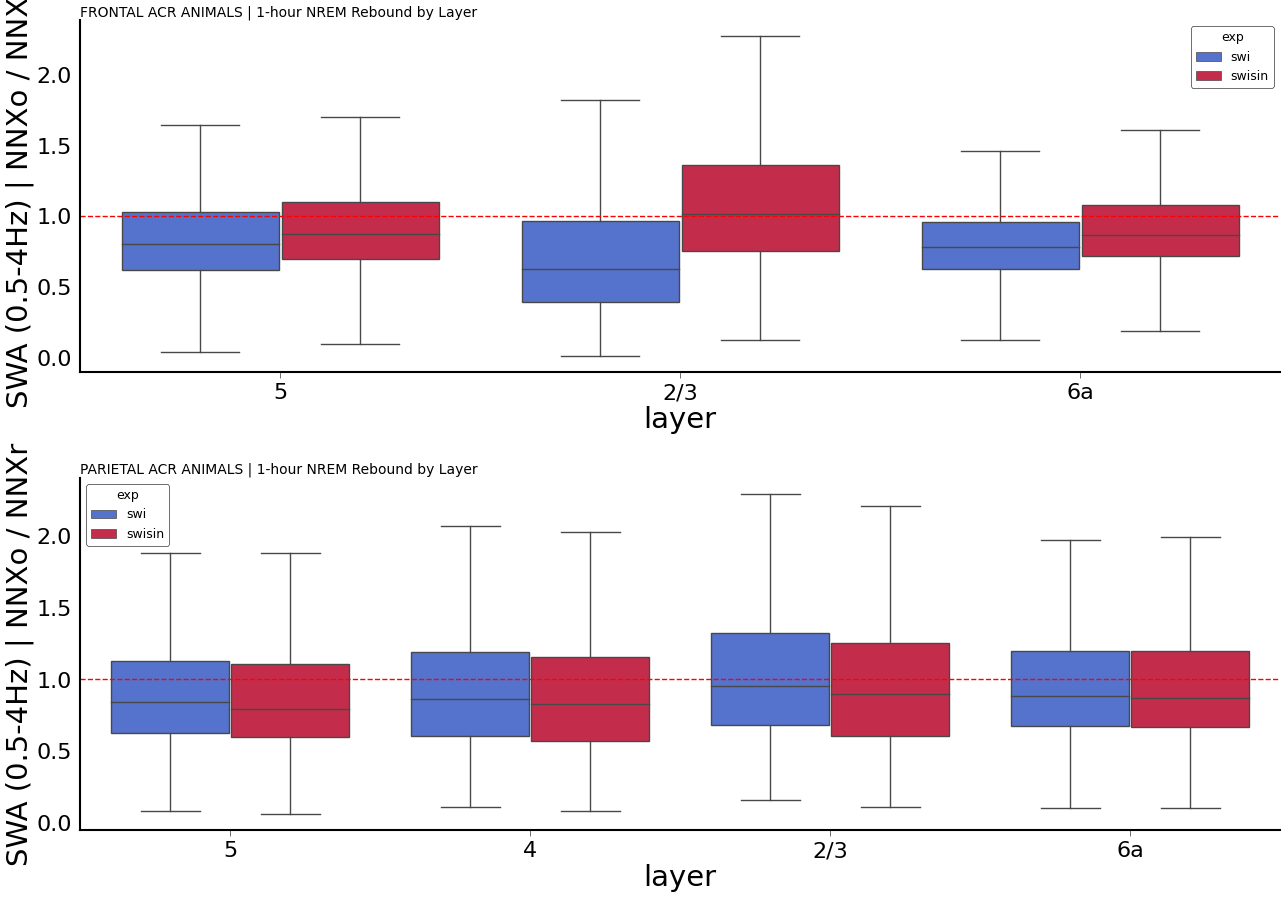

In [33]:
f, ax = plt.subplots(2, 1, figsize = (30, 20))
to_plot = swa_rel.loc[swa_rel['region'] == 'frontal'].exptype('acr')
ax[0] = sns.boxplot(data=to_plot.exp_names(), x='layer', y='rel_bp', hue='exp', showfliers=False, palette=['royalblue', 'crimson'], ax=ax[0])
ax[0].set_title('FRONTAL ACR ANIMALS | 1-hour NREM Rebound by Layer')
ax[0].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')
ax[0].axhline(1, color='r', linestyle='--')

to_plot = swa_rel.loc[swa_rel['region'] == 'parietal'].exptype('acr')
to_plot = to_plot.loc[to_plot['layer'] != '0']
to_plot = to_plot.loc[to_plot['layer'] != 0]
ax[1] = sns.boxplot(data=to_plot.exp_names(), x='layer', y='rel_bp', hue='exp', showfliers=False, palette=['royalblue', 'crimson'], ax=ax[1])
ax[1].set_title('PARIETAL ACR ANIMALS | 1-hour NREM Rebound by Layer')
ax[1].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')
ax[1].axhline(1, color='r', linestyle='--')

f.savefig(f'{save_base}/swa_rel_acr_layer.png', dpi=300)

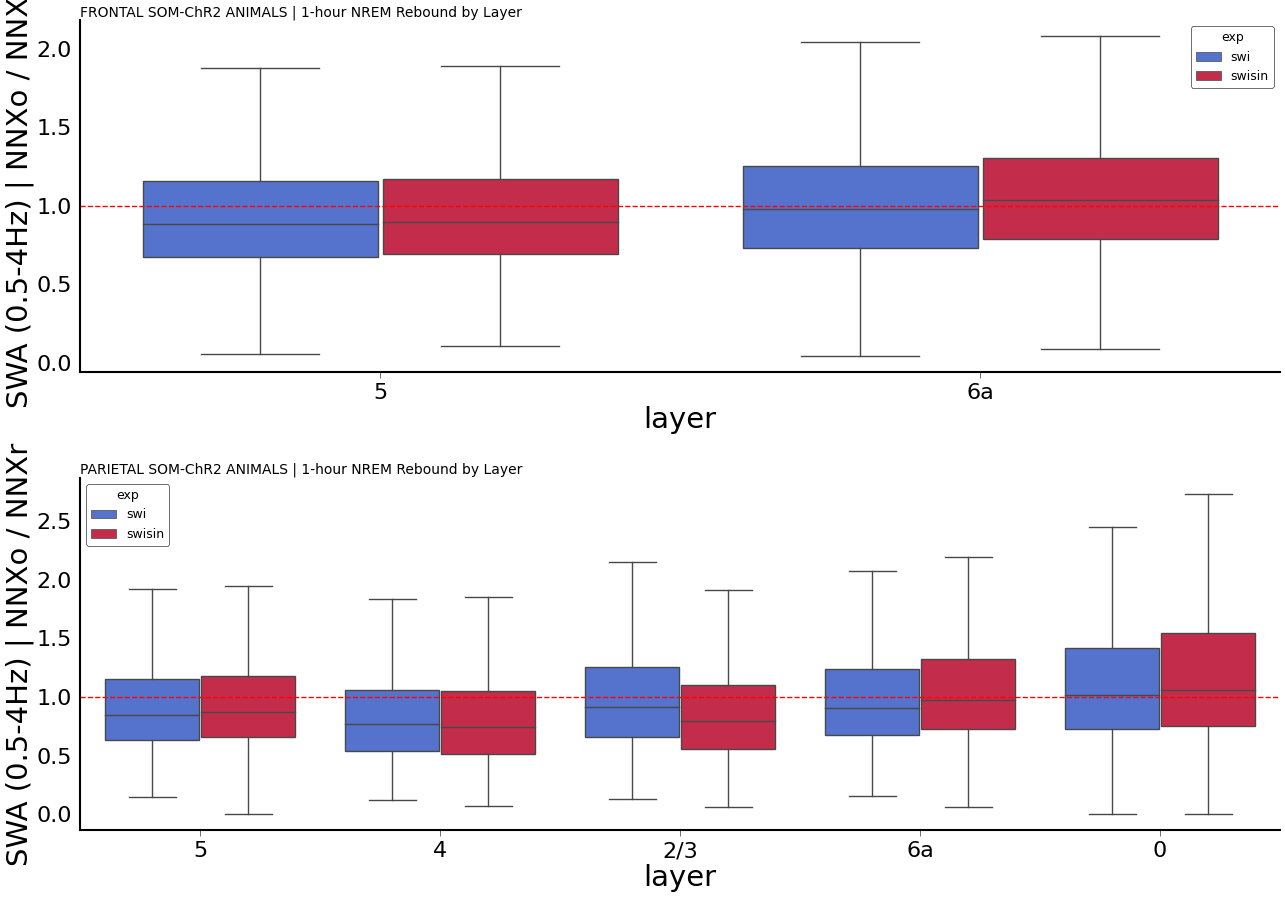

In [34]:
f, ax = plt.subplots(2, 1, figsize = (30, 20))
to_plot = swa_rel.loc[swa_rel['region'] == 'frontal'].exptype('som')
ax[0] = sns.boxplot(data=to_plot.exp_names(), x='layer', y='rel_bp', hue='exp', showfliers=False, palette=['royalblue', 'crimson'], ax=ax[0])
ax[0].set_title('FRONTAL SOM-ChR2 ANIMALS | 1-hour NREM Rebound by Layer')
ax[0].axhline(1, color='r', linestyle='--')
ax[0].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')

to_plot = swa_rel.loc[swa_rel['region'] == 'parietal'].exptype('som')
ax[1] = sns.boxplot(data=to_plot.exp_names(), x='layer', y='rel_bp', hue='exp', showfliers=False, palette=['royalblue', 'crimson'], ax=ax[1])
ax[1].set_title('PARIETAL SOM-ChR2 ANIMALS | 1-hour NREM Rebound by Layer')
ax[1].axhline(1, color='r', linestyle='--')
ax[1].set_ylabel('SWA (0.5-4Hz) | NNXo / NNXr')

f.savefig(f'{save_base}/swa_rel_som_layer.png', dpi=300)

# Relative to Firing Rate

In [74]:
fr_red = pd.read_csv('/home/kdriessen/gh_master/acr/pub/fr_reduction_info.csv')

In [78]:
fr_red.prb('NNXo')['fr_reduction'].values / fr_red.prb('NNXr')['fr_reduction'].values

array([0.73399322, 0.69095253, 0.84175948, 0.73250878, 0.22440735,
       0.90049655, 0.84991456, 0.50036885, 0.8301598 , 0.53821433,
       0.77210159, 0.60787289, 0.78292519])

In [79]:
fr_red_rel = pd.DataFrame()
fr_red_rel['fr_reduction'] = fr_red.prb('NNXo')['fr_reduction'].values / fr_red.prb('NNXr')['fr_reduction'].values
fr_red_rel['exp'] = fr_red.prb('NNXo')['exp'].values
fr_red_rel['subject'] = fr_red.prb('NNXo')['subject'].values
fr_red_rel['fr_reduction'] = 1-fr_red_rel['fr_reduction']

In [98]:
def scale_by_fr(df, fr_df, subject):
    exps = df.sbj(subject)['exp'].unique()
    exps_df = {}
    for exp in exps:
        exps_df[exp] = df.sbj(subject).loc[df.sbj(subject)['exp'] == exp]
        exps_df[exp]['fr_reduction'] = fr_df.sbj(subject).loc[fr_df['exp'] == exp]['fr_reduction'].values[0]
    
    return pd.concat(exps_df.values())

In [101]:
fr_scaled_dfs = {}

for subject in swa_rel.exptype('exp').subject.unique():
    if subject == 'ACR_16':
        continue
    fr_scaled_dfs[subject] = scale_by_fr(swa_rel, fr_red_rel, subject)

swa_with_fr_scaling = pd.concat(fr_scaled_dfs.values())
swa_with_fr_scaling['swa_by_fr'] = swa_with_fr_scaling['rel_bp'] / swa_with_fr_scaling['fr_reduction']

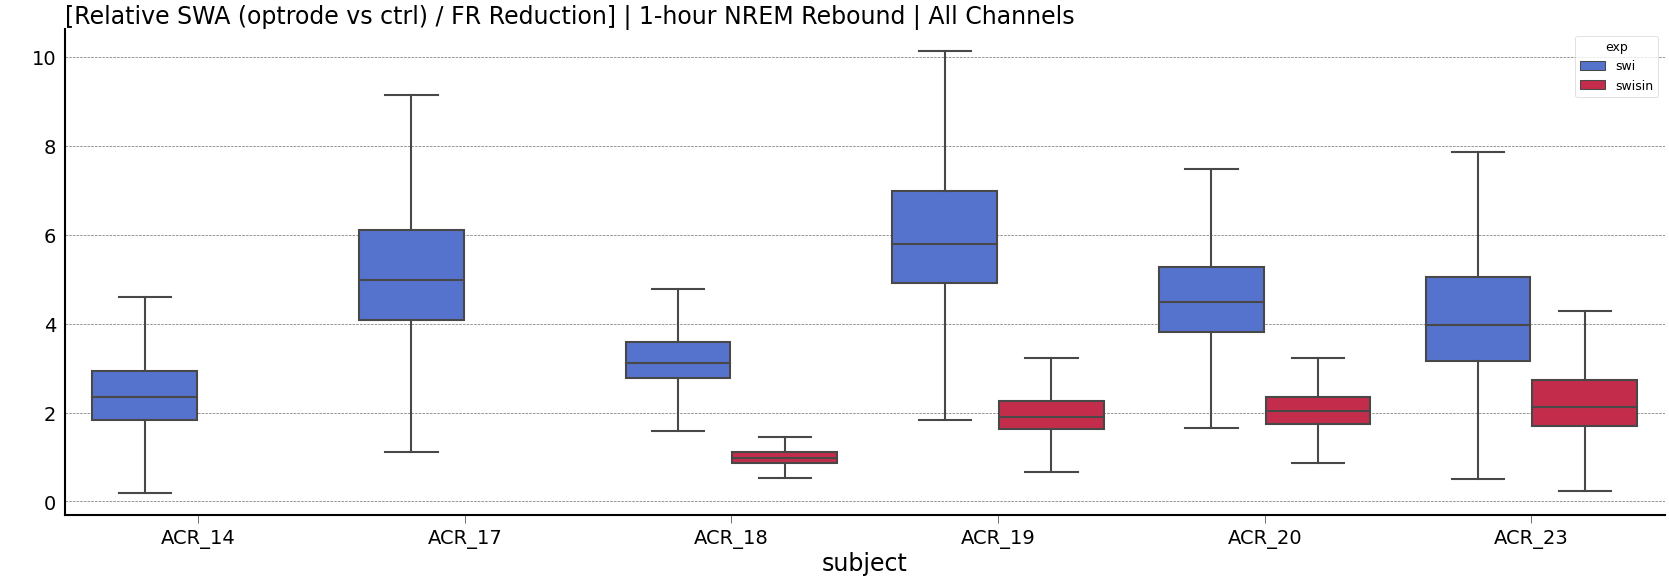

In [109]:
f, ax = plt.subplots()
sns.boxplot(data=swa_with_fr_scaling.exp_names(), x='subject', y='swa_by_fr', hue='exp', showfliers=False, palette=['royalblue', 'crimson'])
ax.set_title('[Relative SWA (optrode vs ctrl) / FR Reduction] | 1-hour NREM Rebound | All Channels')
ax.set_ylabel(' ')
f.savefig(f'{save_base}/swa_rel_by_fr_ACR.png', dpi=300)

# FR reduction vs SWA reduction by Channel

In [120]:
swa_with_fr_scaling

,rel_bp,channel,layer,subject,datetime,store,exp,exp_type,state,region,fr_reduction,swa_by_fr
0,0.732100,1,2/3,ACR_14,2022-10-07 14:37:47.917119,NNXo,swi,exp,NREM,frontal,0.266007,2.752186
1,0.495509,1,2/3,ACR_14,2022-10-07 14:37:49.915967,NNXo,swi,exp,NREM,frontal,0.266007,1.862769
2,2.701852,1,2/3,ACR_14,2022-10-07 14:37:51.914815,NNXo,swi,exp,NREM,frontal,0.266007,10.157081
3,0.883003,1,2/3,ACR_14,2022-10-07 14:37:53.913663,NNXo,swi,exp,NREM,frontal,0.266007,3.319477
4,1.045874,1,2/3,ACR_14,2022-10-07 14:37:55.912511,NNXo,swi,exp,NREM,frontal,0.266007,3.931755
...,...,...,...,...,...,...,...,...,...,...,...,...
24043,0.811409,12,5,ACR_23,2023-07-21 15:15:25.125247,NNXo,swisin,exp,NREM,parietal,0.392127,2.069251
24044,0.866885,13,6a,ACR_23,2023-07-21 15:15:25.125247,NNXo,swisin,exp,NREM,parietal,0.392127,2.210725
24045,0.827765,14,6a,ACR_23,2023-07-21 15:15:25.125247,NNXo,swisin,exp,NREM,parietal,0.392127,2.110962
24046,0.841199,15,6a,ACR_23,2023-07-21 15:15:25.125247,NNXo,swisin,exp,NREM,parietal,0.392127,2.145221


In [166]:
swa_fr_avgs = swa_with_fr_scaling.groupby(['subject', 'exp', 'layer'])['rel_bp'].mean().to_frame().reset_index().sort_values(by=['subject', 'exp', 'layer'])

In [167]:
fr_vals = swa_with_fr_scaling.groupby(['subject', 'exp', 'layer'])['fr_reduction'].mean().to_frame().reset_index().sort_values(by=['subject', 'exp', 'layer'])['fr_reduction'].values

In [168]:
swa_fr_avgs['fr_reduction'] = fr_vals

In [169]:
swa_fr_avgs['swa_reduction'] = 1 - swa_fr_avgs['rel_bp']

In [ ]:
string_array = swa_fr_avgs['channel'].values
integer_array = list(map(int, string_array))
swa_fr_avgs['chan_num'] = integer_array

In [172]:
swa_fr_avgs = swa_fr_avgs[swa_fr_avgs['subject'] != 'ACR_17']

<Axes: xlabel='fr_reduction', ylabel='swa_reduction'>

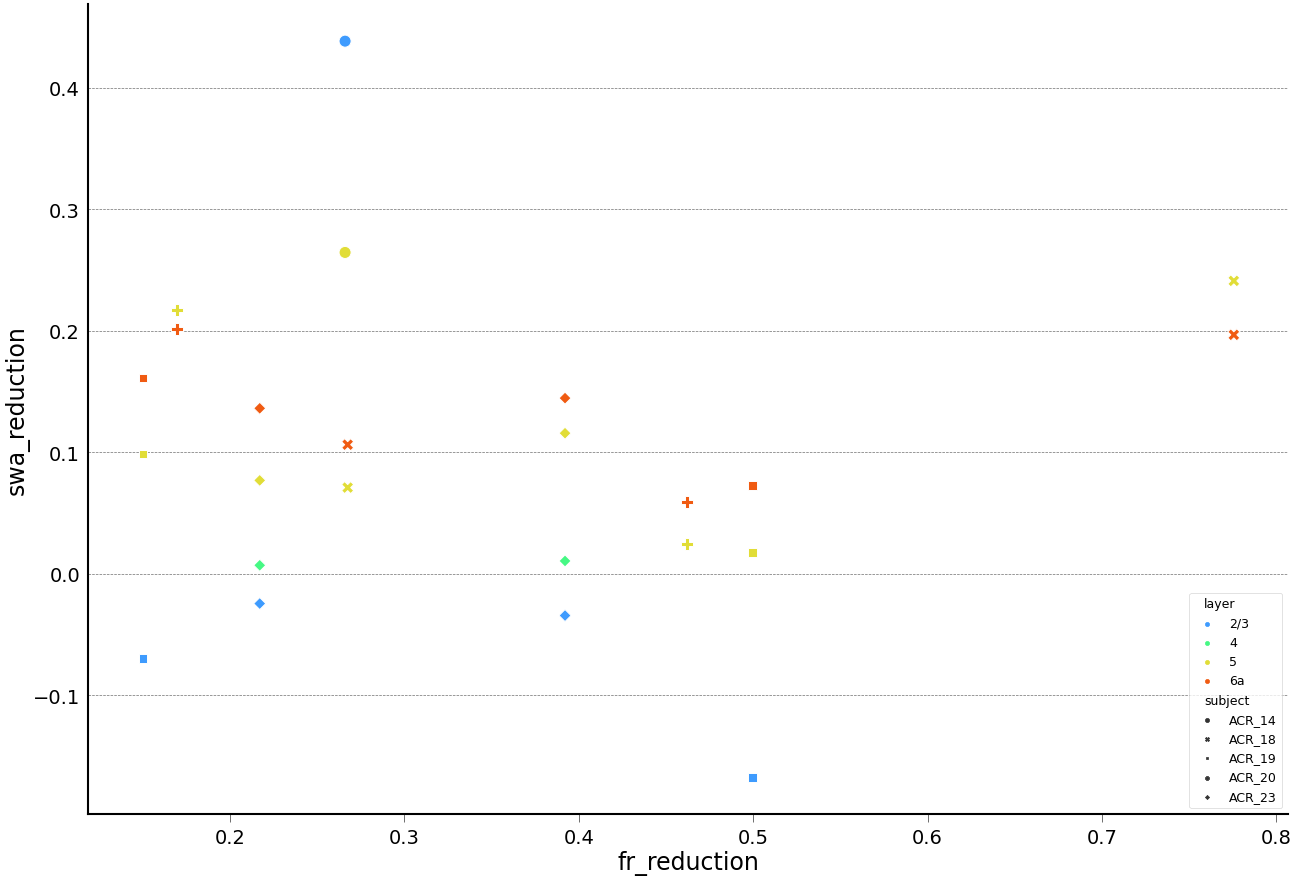

In [175]:
f, ax = plt.subplots(figsize=(30, 20))
chan_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
layer_order = ['2/3', '4', '5', '6a']
sns.scatterplot(data=swa_fr_avgs.exp_names(), x='fr_reduction', y='swa_reduction', hue='layer', hue_order=layer_order, palette='turbo', style='subject', s=300)

In [189]:
chan_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
layer_order = ['2/3', '4', '5', '6a']
fig = px.scatter(swa_fr_avgs.exp_names(), x="fr_reduction", y="swa_reduction", color="exp", symbol='layer', hover_data=['subject', 'layer'], color_discrete_sequence=px.colors.qualitative.T10, title='SWA Reduction vs FR Reduction by Layer')
fig.update_traces(marker=dict(size=10))
fig.show()